<a href="https://colab.research.google.com/github/profliuhao/CSIT599/blob/main/CSIT599_module3_dl_frameworks_notebook_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSIT 599 - Introduction to Deep Learning Frameworks

## Learning Objectives

By the end of this module, you will be able to:
1. **Understand** the core philosophies of TensorFlow/Keras and PyTorch
2. **Build** identical neural networks using different frameworks
3. **Compare** training workflows and APIs across frameworks
4. **Apply** best practices for model development in each framework
5. **Choose** the appropriate framework for different use cases

## Why Use Deep Learning Frameworks?

Building neural networks from scratch (as in Module 1) helps understand fundamentals, but frameworks offer:
- **Automatic Differentiation**: No manual backpropagation implementation
- **Optimized Operations**: GPU acceleration and efficient computations
- **Pre-built Components**: Layers, optimizers, loss functions
- **Ecosystem**: Model deployment, visualization, pre-trained models
- **Community Support**: Extensive documentation and resources

## 1. Environment Setup and Imports

First, let's install and import all necessary libraries. This notebook is designed for Google Colab compatibility.

In [1]:
# Installation commands for Colab (uncomment if needed)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install tensorflow tensorboard

In [2]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

In [3]:
# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from tensorflow.keras.utils import to_categorical

In [4]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

In [5]:
# Check versions and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available (TF): {tf.config.list_physical_devices('GPU')}")
print(f"GPU available (PyTorch): {torch.cuda.is_available()}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

TensorFlow version: 2.19.0
PyTorch version: 2.8.0+cu126
GPU available (TF): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU available (PyTorch): True


## 2. Framework Philosophies and Design Patterns

### TensorFlow/Keras
- **Philosophy**: Production-ready, scalable, high-level abstractions
- **Design**: Static graph (TF 1.x) → Eager execution (TF 2.x)
- **Keras**: High-level API for rapid prototyping
- **Best for**: Production deployment, mobile/edge devices, large-scale systems

### PyTorch
- **Philosophy**: Research-friendly, Pythonic, dynamic computation
- **Design**: Define-by-run with dynamic graphs
- **API**: Lower-level control with intuitive Python syntax
- **Best for**: Research, experimentation, custom architectures

## 3. Data Loading and Preprocessing

Let's load the MNIST dataset using both frameworks' utilities.

In [6]:
# ============ TensorFlow/Keras Data Loading ============
# Keras provides convenient dataset loading functions
(x_train_tf, y_train_tf), (x_test_tf, y_test_tf) = keras.datasets.mnist.load_data()

# Preprocessing for TensorFlow/Keras
# Normalize pixel values to [0, 1] range
x_train_tf = x_train_tf.astype('float32') / 255.0
x_test_tf = x_test_tf.astype('float32') / 255.0

# Reshape for fully connected network (flatten images)
x_train_tf_flat = x_train_tf.reshape(-1, 784)  # 28*28 = 784
x_test_tf_flat = x_test_tf.reshape(-1, 784)

# One-hot encode labels for categorical crossentropy
y_train_tf_cat = to_categorical(y_train_tf, 10)
y_test_tf_cat = to_categorical(y_test_tf, 10)

print(f"TensorFlow Data Shape:")
print(f"  Training: {x_train_tf_flat.shape}, Labels: {y_train_tf_cat.shape}")
print(f"  Testing: {x_test_tf_flat.shape}, Labels: {y_test_tf_cat.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
TensorFlow Data Shape:
  Training: (60000, 784), Labels: (60000, 10)
  Testing: (10000, 784), Labels: (10000, 10)


In [7]:
# ============ PyTorch Data Loading ============
# PyTorch uses transforms for preprocessing pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create DataLoaders for batch processing
# DataLoader handles batching, shuffling, and parallel loading
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"PyTorch Data:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Testing samples: {len(test_dataset)}")
print(f"  Batch size: {batch_size}")
print(f"  Number of batches: {len(train_loader)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.76MB/s]

PyTorch Data:
  Training samples: 60000
  Testing samples: 10000
  Batch size: 64
  Number of batches: 938


## 4. Building Neural Networks: Side-by-Side Comparison

Let's build the **same architecture** in both frameworks:
- Input layer: 784 features (28×28 pixels)
- Hidden layer 1: 128 neurons with ReLU activation
- Dropout: 0.2
- Hidden layer 2: 64 neurons with ReLU activation
- Dropout: 0.2
- Output layer: 10 neurons with softmax activation

In [8]:
# ============ TensorFlow/Keras Model ============

def create_keras_model():
    """
    Create a neural network using Keras Sequential API.
    Keras provides high-level building blocks for quick prototyping.
    """
    model = keras.Sequential([
        # Input layer - specify input shape
        layers.Input(shape=(784,)),

        # Hidden layer 1: Dense (fully connected) with 128 neurons
        layers.Dense(128, activation='relu', name='hidden1'),
        # Dropout for regularization (randomly drops 20% of connections)
        layers.Dropout(0.2),

        # Hidden layer 2: 64 neurons
        layers.Dense(64, activation='relu', name='hidden2'),
        layers.Dropout(0.2),

        # Output layer: 10 neurons (one per class) with softmax
        layers.Dense(10, activation='softmax', name='output')
    ])

    return model

# Create and display model
keras_model = create_keras_model()
keras_model.summary()  # Print model architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ============ PyTorch Model ============

class PyTorchNet(nn.Module):
    """
    PyTorch model using nn.Module base class.
    Requires explicit definition of forward pass.
    """
    def __init__(self):
        super(PyTorchNet, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(784, 128)  # First fully connected layer
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)   # Second fully connected layer
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 10)    # Output layer

    def forward(self, x):
        """
        Define the forward pass explicitly.
        This gives more control over data flow.
        """
        # Flatten input if needed
        x = x.view(-1, 784)  # Reshape to (batch_size, 784)

        # Forward pass through layers
        x = F.relu(self.fc1(x))  # Apply ReLU activation
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.log_softmax(self.fc3(x), dim=1)  # Log softmax for numerical stability

        return x

# Create model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pytorch_model = PyTorchNet().to(device)

# Count parameters
total_params = sum(p.numel() for p in pytorch_model.parameters())
print(f"PyTorch Model: {total_params:,} parameters")
print(pytorch_model)

PyTorch Model: 109,386 parameters
PyTorchNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## 5. Model Compilation and Optimization Setup

Both frameworks require specifying:
- **Optimizer**: Algorithm for updating weights (SGD, Adam, etc.)
- **Loss Function**: Measure of prediction error
- **Metrics**: Performance indicators to track

In [10]:
# ============ Keras Compilation ============
# Keras uses compile() to configure the training process

keras_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
    loss='categorical_crossentropy',  # Multi-class classification loss
    metrics=['accuracy']  # Track accuracy during training
)

print("Keras model compiled successfully!")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss: Categorical Crossentropy")

Keras model compiled successfully!
Optimizer: Adam (lr=0.001)
Loss: Categorical Crossentropy


In [11]:
# ============ PyTorch Optimization Setup ============
# PyTorch requires separate optimizer and loss function objects

# Define optimizer (updates model parameters)
pytorch_optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

# Define loss function (negative log likelihood for classification)
pytorch_criterion = nn.NLLLoss()  # Works with log_softmax output

print("PyTorch optimization setup complete!")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss: Negative Log Likelihood")

PyTorch optimization setup complete!
Optimizer: Adam (lr=0.001)
Loss: Negative Log Likelihood


## 6. Training Loops: Framework Comparison

### Key Differences:
- **Keras**: High-level `fit()` method handles everything
- **PyTorch**: Manual training loop gives more control

In [12]:
# ============ Keras Training ============
# Simple and concise training with callbacks

# Define callbacks for additional functionality
keras_callbacks = [
    # Early stopping prevents overfitting
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    # Reduce learning rate when loss plateaus
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Train the model
print("Training Keras model...")
keras_history = keras_model.fit(
    x_train_tf_flat, y_train_tf_cat,  # Training data
    batch_size=64,
    epochs=10,
    validation_split=0.1,  # Use 10% of training data for validation
    callbacks=keras_callbacks,
    verbose=1  # Show progress bar
)

Training Keras model...
Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7891 - loss: 0.6873 - val_accuracy: 0.9625 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9419 - loss: 0.1987 - val_accuracy: 0.9700 - val_loss: 0.0922 - learning_rate: 0.0010
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9570 - loss: 0.1460 - val_accuracy: 0.9748 - val_loss: 0.0844 - learning_rate: 0.0010
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9648 - loss: 0.1168 - val_accuracy: 0.9768 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9693 - loss: 0.0998 - val_accuracy: 0.9785 - val_loss: 0.0707 - learning_rate: 0.0010
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9722 - loss: 0.0891 - val_accuracy: 0.9808 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 

In [13]:
# ============ PyTorch Training ============
# Manual training loop provides full control

def train_pytorch_model(model, train_loader, test_loader, epochs=10):
    """
    Manual training loop for PyTorch.
    This gives complete control over the training process.
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # ===== Training Phase =====
        model.train()  # Set model to training mode (enables dropout)
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            # Move data to device (GPU if available)
            data, target = data.to(device), target.to(device)

            # Zero gradients from previous step
            pytorch_optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = pytorch_criterion(output, target)

            # Backward pass (compute gradients)
            loss.backward()

            # Update weights
            pytorch_optimizer.step()

            # Track metrics
            train_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            # Print progress
            if batch_idx % 100 == 0:
                print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Calculate epoch metrics
        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # ===== Validation Phase =====
        model.eval()  # Set model to evaluation mode (disables dropout)
        test_loss = 0
        correct = 0

        with torch.no_grad():  # Disable gradient computation for efficiency
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += pytorch_criterion(output, target).item()
                _, predicted = output.max(1)
                correct += predicted.eq(target).sum().item()

        # Calculate validation metrics
        avg_test_loss = test_loss / len(test_loader)
        test_acc = 100. * correct / len(test_dataset)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

# Train the PyTorch model
print("Training PyTorch model...")
pytorch_history = train_pytorch_model(pytorch_model, train_loader, test_loader, epochs=10)

Training PyTorch model...
  Batch 0/938, Loss: 2.3151
  Batch 100/938, Loss: 0.5047
  Batch 200/938, Loss: 0.4591
  Batch 300/938, Loss: 0.3720
  Batch 400/938, Loss: 0.3175
  Batch 500/938, Loss: 0.1360
  Batch 600/938, Loss: 0.1951
  Batch 700/938, Loss: 0.1122
  Batch 800/938, Loss: 0.2801
  Batch 900/938, Loss: 0.2027
Epoch 1/10:
  Train Loss: 0.3434, Train Acc: 89.68%
  Test Loss: 0.1501, Test Acc: 95.19%
  Batch 0/938, Loss: 0.2556
  Batch 100/938, Loss: 0.1487
  Batch 200/938, Loss: 0.1664
  Batch 300/938, Loss: 0.1445
  Batch 400/938, Loss: 0.1741
  Batch 500/938, Loss: 0.1555
  Batch 600/938, Loss: 0.1102
  Batch 700/938, Loss: 0.1676
  Batch 800/938, Loss: 0.0833
  Batch 900/938, Loss: 0.2741
Epoch 2/10:
  Train Loss: 0.1672, Train Acc: 95.00%
  Test Loss: 0.1064, Test Acc: 96.61%
  Batch 0/938, Loss: 0.1292
  Batch 100/938, Loss: 0.0631
  Batch 200/938, Loss: 0.1469
  Batch 300/938, Loss: 0.0388
  Batch 400/938, Loss: 0.2954
  Batch 500/938, Loss: 0.1400
  Batch 600/938, Los

## 7. Model Evaluation and Visualization

In [14]:
# ============ Evaluate Keras Model ============
keras_loss, keras_accuracy = keras_model.evaluate(x_test_tf_flat, y_test_tf_cat, verbose=0)
print(f"Keras Model Performance:")
print(f"  Test Loss: {keras_loss:.4f}")
print(f"  Test Accuracy: {keras_accuracy:.4f}")

# ============ Evaluate PyTorch Model ============
pytorch_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = pytorch_model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

pytorch_accuracy = correct / total
print(f"\nPyTorch Model Performance:")
print(f"  Test Accuracy: {pytorch_accuracy:.4f}")

Keras Model Performance:
  Test Loss: 0.0651
  Test Accuracy: 0.9820

PyTorch Model Performance:
  Test Accuracy: 0.9783


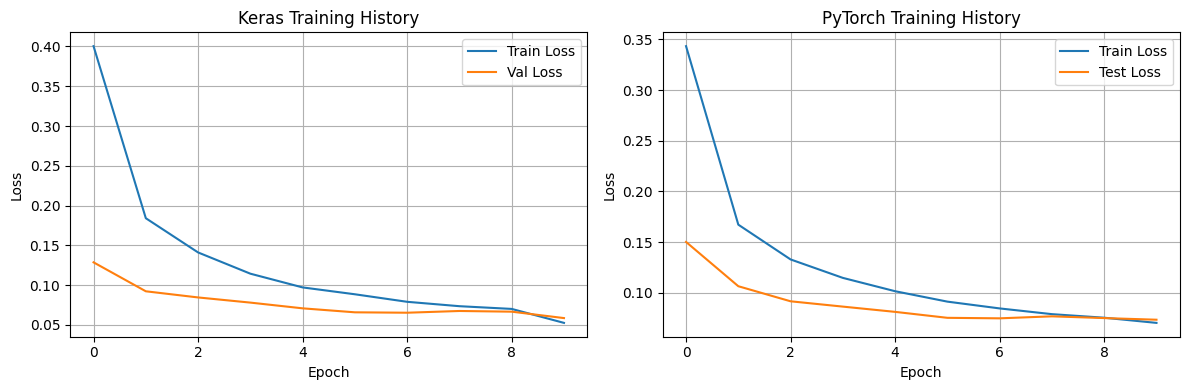

In [15]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Keras training history
axes[0].plot(keras_history.history['loss'], label='Train Loss')
axes[0].plot(keras_history.history['val_loss'], label='Val Loss')
axes[0].set_title('Keras Training History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# PyTorch training history
axes[1].plot(pytorch_history[0], label='Train Loss')
axes[1].plot(pytorch_history[1], label='Test Loss')
axes[1].set_title('PyTorch Training History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 8. Model Saving and Loading

### Best Practices for Model Persistence

In [17]:
# ============ Keras Model Saving ============

# Method 1: Save entire model (architecture + weights + optimizer state)
keras_model.save('keras_model_complete.h5')
print("Keras model saved (complete)")

# Method 2: Save only weights
keras_model.save_weights('keras_model.weights.h5')
print("Keras model weights saved")

# Method 3: Save as TensorFlow SavedModel format (recommended for production)
keras_model.save('keras_saved_model.keras')
print("Keras model saved in SavedModel format")

# Loading models
# loaded_model = keras.models.load_model('keras_model_complete.h5')
# keras_model.load_weights('keras_model.weights.h5')

Keras model saved (complete)
Keras model weights saved
Keras model saved in SavedModel format


In [18]:
# ============ PyTorch Model Saving ============

# Method 1: Save entire model (not recommended, less portable)
torch.save(pytorch_model, 'pytorch_model_complete.pth')
print("PyTorch model saved (complete)")

# Method 2: Save only state dict (recommended)
torch.save(pytorch_model.state_dict(), 'pytorch_model_weights.pth')
print("PyTorch model state dict saved")

# Method 3: Save checkpoint with additional information
checkpoint = {
    'epoch': 10,
    'model_state_dict': pytorch_model.state_dict(),
    'optimizer_state_dict': pytorch_optimizer.state_dict(),
    'loss': pytorch_history[1][-1],
}
torch.save(checkpoint, 'pytorch_checkpoint.pth')
print("PyTorch checkpoint saved")

# Loading models
# loaded_model = torch.load('pytorch_model_complete.pth')
# pytorch_model.load_state_dict(torch.load('pytorch_model_weights.pth'))

PyTorch model saved (complete)
PyTorch model state dict saved
PyTorch checkpoint saved


## 10. Framework Comparison Summary

| Aspect | TensorFlow/Keras | PyTorch |
|--------|------------------|----------|
| **Learning Curve** | Easier for beginners | Steeper, more Pythonic |
| **API Style** | High-level abstractions | Lower-level, explicit |
| **Debugging** | Can be challenging | Easier with Python debuggers |
| **Production** | Excellent deployment tools | Improving (TorchServe, etc.) |
| **Mobile/Edge** | TensorFlow Lite | PyTorch Mobile |
| **Research** | Good, improving | Excellent, preferred |
| **Community** | Large, enterprise-focused | Large, research-focused |
| **Visualization** | TensorBoard (excellent) | TensorBoard support, Weights & Biases |
| **Pre-trained Models** | TensorFlow Hub | PyTorch Hub, Hugging Face |

## 11. Best Practices and Common Pitfalls

### TensorFlow/Keras Best Practices:
1. **Use tf.data API** for efficient data pipelines
2. **Enable mixed precision** for faster training on GPUs
3. **Use callbacks** for monitoring and early stopping
4. **Profile with TensorBoard** to identify bottlenecks

### PyTorch Best Practices:
1. **Always call model.eval()** during inference
2. **Use torch.no_grad()** context for validation
3. **Move data to device** before operations
4. **Zero gradients** before backward pass

### Common Pitfalls to Avoid:
- **Shape mismatches**: Always verify tensor dimensions
- **Forgetting to normalize**: Input preprocessing is crucial
- **Not setting seeds**: Reproducibility requires fixed seeds
- **Memory leaks**: Detach tensors when needed (PyTorch)
- **Wrong loss functions**: Match loss to output activation

## 12. Practice Exercises

Complete the following exercises to reinforce your understanding of deep learning frameworks.

### Exercise 1: Implement a CNN in Both Frameworks
Create a convolutional neural network for MNIST with:
- 2 convolutional layers (32 and 64 filters)
- MaxPooling after each conv layer
- 2 fully connected layers
- Compare training times and accuracy






In [ ]:
## You Solution here




### Exercise 2: Data Augmentation
Add data augmentation to the training pipeline:
- Random rotation (±15 degrees)
- Random zoom (0.9-1.1)
- Compare model performance with/without augmentation

In [ ]:
## You Solution here



## Conclusion and Next Steps

### Key Takeaways:
1. **Both frameworks are powerful**: Choice depends on use case
2. **Keras for simplicity**: Quick prototyping and standard models
3. **PyTorch for flexibility**: Research and custom architectures
4. **Transferable concepts**: Core deep learning principles apply to both

### Recommended Next Steps:
1. **Experiment with both frameworks** on your own projects
2. **Explore advanced features**: Custom training loops, mixed precision, distributed training
3. **Join communities**: Forums, GitHub, research papers
4. **Build projects**: Apply frameworks to real-world problems

### Additional Resources:
- [TensorFlow Documentation](https://www.tensorflow.org/)
- [PyTorch Documentation](https://pytorch.org/)
- [Papers with Code](https://paperswithcode.com/) - Implementations in both frameworks
- [Hugging Face](https://huggingface.co/) - Pre-trained models and datasets